# Représentation interactive de l'espace latent

Note : ce Notebook doit être utilisé sur Jupyter Notebook et non pas Google Colaboratory, qui ne permet pas d'interactivité dans la visualisation de données.

In [1]:
from __future__ import print_function
import argparse
import torch
import torchvision 
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os
import numpy as np
from os.path import join as oj
import matplotlib.pyplot as plt
plt.style.use('default')
def to_im(x):
    return x.cpu().detach().numpy().reshape((28, 28)) # format des images MNIST

In [2]:
torch.cuda.is_available()

True

In [3]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

In [4]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512).to(device)
        self.linear2 = nn.Linear(512, latent_dims).to(device)
        self.linear3 = nn.Linear(512, latent_dims).to(device)
        
        self.N = torch.distributions.Normal(0, 1)
        if torch.cuda.is_available():
          self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
          self.N.scale = self.N.scale.cuda()
        else:
          self.N.loc = self.N.loc
          self.N.scale = self.N.scale
        self.kl = 0
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1).to(device)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x).to(device)
        sigma = torch.exp(self.linear3(x)).to(device)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512).to(device)
        self.linear2 = nn.Linear(512, 784).to(device)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, activation = 's'):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512).to(device)
        self.linear2 = nn.Linear(512, 784).to(device)
        self.activation = activation

    def forward(self, z):
        if self.activation == 'relu':
          z= torch.relu(self.linear1(z))
        elif self.activation == 'tan':
          z= torch.tanh(self.linear1(z))
        else:
          z= torch.sigmoid(self.linear1(z))

        z = torch.sigmoid(self.linear2(z))
        
        return z.reshape((-1, 1, 28, 28))

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [8]:
def train(autoencoder, data, epochs=50):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
        if epoch % 10 == 0:
            print('Epoch :', epoch, ' // Loss : ', float(loss))
    return autoencoder

In [9]:
latent_dims = 2
VAE = VariationalAutoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), 
               download=True),
        batch_size=128,
        shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
epochs = 100
vae = train(VAE, data, epochs) # 4min21 pour 50 époques

Epoch : 0  // Loss :  4584.58447265625
Epoch : 10  // Loss :  4039.271484375
Epoch : 20  // Loss :  3755.887451171875
Epoch : 30  // Loss :  3564.526123046875
Epoch : 40  // Loss :  3404.492919921875
Epoch : 50  // Loss :  3452.056640625
Epoch : 60  // Loss :  3801.4189453125
Epoch : 70  // Loss :  3524.4541015625
Epoch : 80  // Loss :  3445.8271484375
Epoch : 90  // Loss :  3346.6015625


# To save the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/INF8225 - Projet/gan-vae-pretrained-pytorch-master/gan-vae-pretrained-pytorch-master/mnist_vae/trained_VAE_100_epochs.pt'

In [ ]:
torch.save(VAE, PATH)

# To load the model

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
PATH = '/content/drive/MyDrive/INF8225 - Projet/gan-vae-pretrained-pytorch-master/gan-vae-pretrained-pytorch-master/mnist_vae/trained_VAE_100_epochs.pt'

In [13]:
vae = torch.load(PATH)
vae.eval()

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2, bias=True)
    (linear3): Linear(in_features=512, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=784, bias=True)
  )
)

# Space representation

In [14]:
%cd drive/MyDrive/INF8225 - Projet/gan-vae-pretrained-pytorch-master/gan-vae-pretrained-pytorch-master/mnist_vae

/content/drive/.shortcut-targets-by-id/1k6FStnTWK1ADzpkZw89mKpfR-fW0JMDn/INF8225 - Projet/gan-vae-pretrained-pytorch-master/gan-vae-pretrained-pytorch-master/mnist_vae


In [15]:
from lenet import LeNet5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = LeNet5().eval()
net.load_state_dict(torch.load('lenet_epoch=12_test_acc=0.991.pth'))
net = net.to(device)

In [16]:
print(net)

LeNet5(
  (convnet): Sequential(
    (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (s2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu3): ReLU()
    (s4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (relu5): ReLU()
  )
  (fc): Sequential(
    (f6): Linear(in_features=120, out_features=84, bias=True)
    (relu6): ReLU()
    (f7): Linear(in_features=84, out_features=10, bias=True)
    (sig7): LogSoftmax(dim=-1)
  )
)


In [19]:
from PIL import Image

def space_representation(autoencoder, r0=(-5, 10), r1=(-10, 5), n=10):
    w = 28
    img = np.zeros((n*w, n*w))
    pred = np.zeros((n,n))
    vector_imgs = np.zeros((n*n, 1, 32, 32))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            # For a point (x, y) in latent space, decode it to find its reconstruction x_hat
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat_np = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat_np
            x_hat_pil = Image.fromarray(x_hat_np)
            

            # Classify the reconstruction
            T = torchvision.transforms.Resize((32,32))
            vector_imgs[j*n+i] = T(x_hat_pil)#.to('cpu').detach().numpy()

    prediction = net(torch.from_numpy(vector_imgs).to(device, dtype=torch.float)).to('cpu').detach().numpy()
    prediction = np.argmax(prediction, axis=1) 
    prediction_square = prediction.reshape((n,n))
    prediction_square = np.rot90(prediction_square, k=1, axes=(0, 1))
    return img, prediction_square, prediction

In [23]:
def plot_space_representation_basic(prediction, r0, r1, n):
    pos = np.zeros((n,n,2))
    for i in range(prediction.shape[0]):
      for j in range(prediction.shape[0]):
        pos[i,j,0] = r0[1] - (r0[1] - r0[0])*1/n*i
        pos[i,j,1] = r0[1] - (r0[1] - r0[0])*1/n*j
    
    plt.figure(figsize=(12,10))
    plt.scatter(pos[:, :, 1], pos[:, :, 0], c=prediction, cmap='tab10')
    plt.colorbar()
    plt.title('Représentation de l\'espace latent avec interpolation')
    plt.show()


In [24]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_space_representation_interactive(all_img, prediction, r0, r1, n):
    width = 28
    pos = np.zeros((n,n,2))
    for i in range(0, n):
        for j in range(0, n):
            
            pos[i,j,0] = r0[0] + (r0[1] - r0[0])*1/(n-1)*i
            pos[i,j,1] = r0[0] + (r0[1] - r0[0])*1/(n-1)*j

    fig, ax = plt.subplots()
    cmap = 'tab10'

    img = all_img[0:28, 0:28]
    imagebox = OffsetImage(img, zoom=1.0)
    imagebox.image.axes = ax
    
    annot = AnnotationBbox(imagebox, xy=(0,0), xybox=(width,width),
                        xycoords="data", boxcoords="offset points", pad=0.5,
                        arrowprops=dict( arrowstyle="->", connectionstyle="arc3,rad=-0.3"))
    annot.set_visible(False)
    ax.add_artist(annot)
    
    prediction = np.rot90(prediction.reshape(n,n), k=1, axes=(0, 1))
    prediction = prediction.flatten()
    
    sc = plt.scatter(pos[:, :, 0].flatten(), pos[:, :, 1].flatten(), c=np.squeeze(prediction), cmap='tab10')

    
    def update_annot(ind):
        i = ind["ind"][0]
        pos = sc.get_offsets()[i]
        annot.xy = (pos[0], pos[1])
        pos_i, pos_j = pos[0], pos[1]
        i, j = int((pos_i+r0[1])/(r0[1]-r0[0])*(n-1)), int((pos_j+r1[1])/(r1[1]-r1[0])*(n-1))
        img = all_img[28*i:28*(i+1), 28*j:28*(j+1)]
        imagebox.set_data(img)

    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == ax:
            cont, ind = sc.contains(event)
            if cont:
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)
    plt.colorbar()
    plt.title('Représentation de l\'espace latent avec interpolation')
    plt.show()

#### Représentation basique de l'espace latent 

Représentation de l'espace latent avec n faible (quadrillage grossier)

In [20]:
r0 = (-3, 3)
r1 = (-3, 3)
n = 10
img, pred_square, pred = space_representation(vae, r0=r0, r1=r1, n=n)

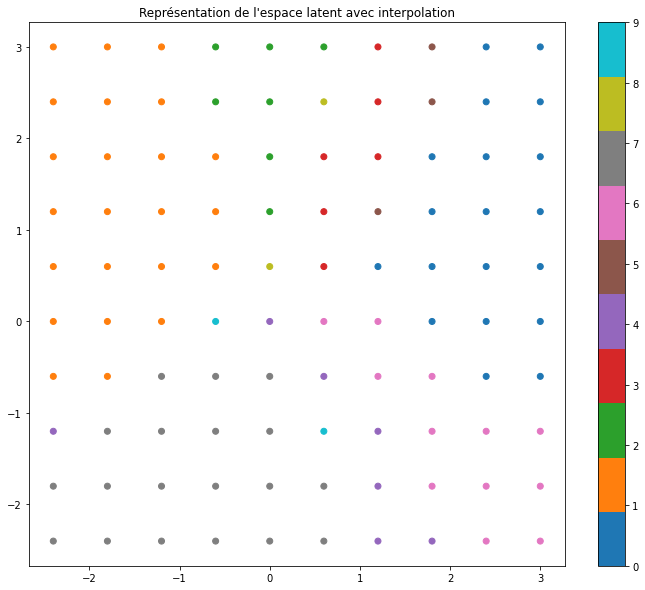

Text(0.5, 1.0, "Représentation de l'espace latent avec interpolation")

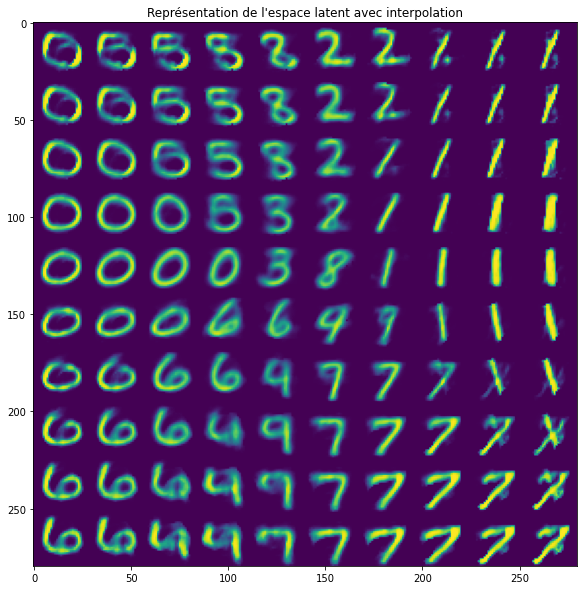

In [22]:
plot_space_representation_basic(pred_square, r0, r1, n)

plt.figure(figsize=(12,10))
plt.imshow(img)
plt.title('Représentation de l\'espace latent avec interpolation')

#### Représentation interactive de l'espace latent 

Représentation de l'espace latent avec n plus grand (quadrillage fin)

In [25]:
r0 = (-3, 3)
r1 = (-3, 3)
n = 40
img, pred_square, pred = space_representation(vae, r0=r0, r1=r1, n=n)

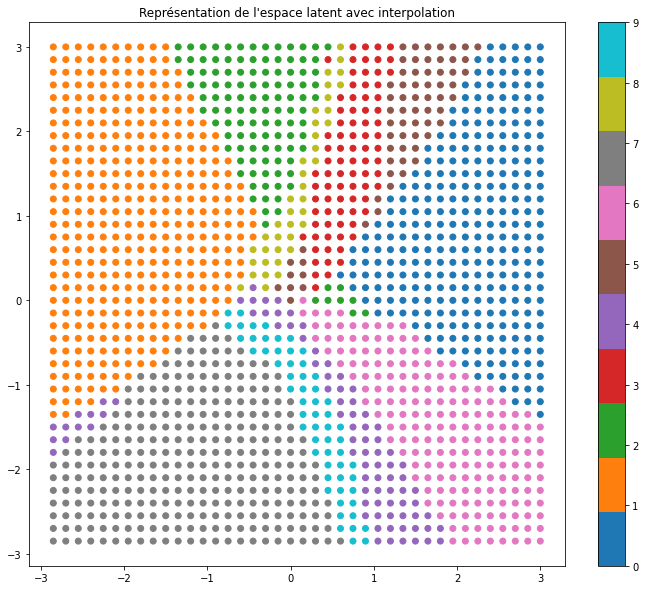

In [26]:
plot_space_representation_basic(pred_square, r0, r1, n)


In [27]:
from matplotlib import interactive
interactive(True)
%matplotlib qt

plot_space_representation_interactive(img, pred, r0, r1, n)

ImportError: ignored